In [1]:
!git clone https://github.com/lu0x1a0/EURUSDPriceAnalysis.git
!mv EURUSDPriceAnalysis/* .
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib
!pip install numpy==1.20.0
!pip install torchinfo

Cloning into 'EURUSDPriceAnalysis'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 226 (delta 55), reused 125 (delta 37), pack-reused 80
Receiving objects: 100% (226/226), 48.83 MiB | 13.66 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Checking out files: 100% (51/51), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3641    0  3641    0     0  16254      0 --:--:-- --:--:-- --:--:-- 16254
100  503k  100  503k    0     0   709k      0 --:--:-- --:--:-- --:--:--  709k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3705    0  3705    0     0  18525      0 --:--:-- --:--:-- --:--:-- 18525
100  406k  100  406k    0     0   625k      0 --:--:-- --:--

In [1]:
from DataManipulation.DataHandler import getOHLC_pickle, getOHLC_raw
#data = getOHLC_pickle("EURUSD_M_2010_2021.pkl")
data = getOHLC_raw()
data = data.resample('1H').agg({'Open': 'first', 
                        'High': 'max', 
                        'Low': 'min', 
                        'Close': 'last'}).dropna()

In [2]:
#generates the indicators
from DataManipulation.indicators import DEMA, MYEMA, D1
demaperiod = [9]
for p in demaperiod:
    data['dema'+str(p)] = DEMA(data['Close'],p)
    data['D1dema'+str(p)] = D1(data['dema'+str(p)])
#    data['normD1dema'+str(p)] = MaxMinRollNorm(data['D1dema'+str(p)], 24*250) # 250 approximated larger than all trading days in a year
emaperiod = [50,100]
for p in emaperiod:
    data['ema'+str(p)] = MYEMA(data['Close'],p)
    data['D1ema'+str(p)] = D1(data['ema'+str(p)])

stdperiod = [9,100,300]
for p in stdperiod:
    data['std'+str(p)+"_dema9"]  = data['dema9'].rolling(p).std()
    data['std'+str(p)+"_D1dema9"]= data['D1dema9'].rolling(p).std()
    for e in emaperiod:
        data['std'+str(p)+"_ema"+str(e)] = data["ema"+str(e)].rolling(p).std()
        data['std'+str(p)+"_D1ema"+str(e)] = data["D1ema"+str(e)].rolling(p).std()
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'dema9', 'D1dema9', 'ema50', 'D1ema50',
       'ema100', 'D1ema100', 'std9_dema9', 'std9_D1dema9', 'std9_ema50',
       'std9_D1ema50', 'std9_ema100', 'std9_D1ema100', 'std100_dema9',
       'std100_D1dema9', 'std100_ema50', 'std100_D1ema50', 'std100_ema100',
       'std100_D1ema100', 'std300_dema9', 'std300_D1dema9', 'std300_ema50',
       'std300_D1ema50', 'std300_ema100', 'std300_D1ema100'],
      dtype='object')


In [4]:
from DataManipulation.indicators import MaxMinRollScaled,MaxMinRollNorm
import pandas as pd
#prediction_ind = ['D1dema9','std9_dema9','std9_D1dema9', 'std100_dema9', 'std100_D1dema9', 'std300_dema9','std300_D1dema9']
prediction_ind = ['D1dema9','std9_dema9','std9_D1dema9', 'std100_dema9', 'std100_D1dema9', "D1ema100","std9_ema100"]

preds = pd.DataFrame()
for n in prediction_ind:
    if n[0:3] == 'std':
        preds[n+"_norm"] = MaxMinRollNorm(data[n], 24*250)
    elif n[0:1] == 'D':
        preds[n+"_norm"] = MaxMinRollScaled(data[n], 24*250)        
    else:
        print("I Screwed up")
        print(n,n[0:4],n[0:1])
preds.tail()

,D1dema9_norm,std9_dema9_norm,std9_D1dema9_norm,std100_dema9_norm,std100_D1dema9_norm,D1ema100_norm,std9_ema100_norm
Date,,,,,,,
2021-09-30 19:00:00,-0.029899,0.035342,0.157625,0.417056,0.216130,-0.228722,0.451697
2021-09-30 20:00:00,-0.070373,0.031738,0.166833,0.421059,0.216888,-0.251455,0.444278
2021-09-30 21:00:00,0.013958,0.035424,0.145746,0.424265,0.215617,-0.212239,0.439791
2021-09-30 22:00:00,0.019615,0.033126,0.123020,0.426708,0.215817,-0.203599,0.439113
2021-09-30 23:00:00,0.006468,0.033670,0.104754,0.428453,0.214252,-0.204322,0.435391


In [5]:
from numpy.lib.stride_tricks import sliding_window_view
raw =  preds.dropna().to_numpy()
wind = sliding_window_view(raw,window_shape = 3*5*24, axis=0)
#print(wind[-1,:])
print(wind.shape)
#print(wind[~pd.isna(wind)].shape)
x = wind[:-4,:]
#target_column = "std100_dema9_norm"
target_column = "D1dema9_norm"
y = wind[4:,0,-4:]
print(x.shape,y.shape)

(66590, 7, 360)
(66586, 7, 360) (66586, 4)


-0.00044024213553794575 0.06299913127416083


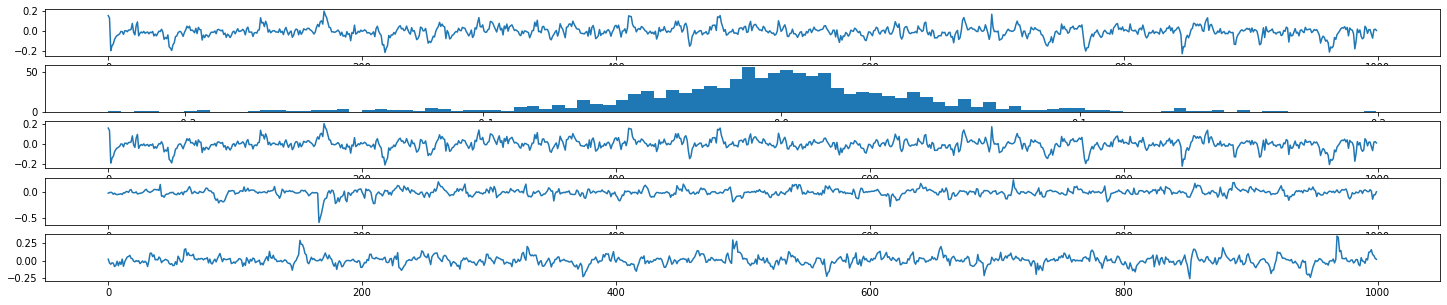

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5,1)
fig.set_size_inches(25,5)
axes[0].plot(preds['D1dema9_norm'].to_numpy()[-1000:])
axes[1].hist(preds['D1dema9_norm'].iloc[-1000:],bins=100)
print(preds['D1dema9_norm'].mean(), preds['D1dema9_norm'].std()) 
# it seems as after standardizing (divide by rolling std est of a year), the avg change is down, i.e. EUR buys less USD.
axes[2].plot(y[:,3][-1000:]) # might consider to only divide, not subtract minimum as direction might be useful?
axes[3].plot(y[:,3][-2000:-1000])
axes[4].plot(y[:,3][-3000:-2000])
plt.show()

In [9]:
def TrainingLoop(epochs, trainloader, net, criterion,optimiser):
    print("Start training...")
    for epoch in range(epochs):
        total_loss = 0
        total_timeframes = 0
        #total_correct = 0
        i = 0
        for batch in trainloader:           # Load batch
            batch_x, batch_y = batch 
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            #print([x.get_device() for x in net.parameters()])
            #print(next(net.parameters()).is_cuda)
            #print(batch_x.get_device())
            preds = net(batch_x)             # Process batch
            #print(preds.shape,batch_y.shape)
            loss = criterion(preds, batch_y) # Calculate loss
            i += 1
            optimiser.zero_grad()
            loss.backward()                 # Calculate gradients
            optimiser.step()                # Update weights

            output = preds.argmax(dim=1)

            total_loss += loss.item()
            total_timeframes += batch_y.size(0)

        print('epoch {0} total_correct: {1} loss: {2:.2f} acc: {3:.2f}'.format(
                    epoch,-1, total_loss, -1) )

In [14]:
from torch.utils.data import TensorDataset
import torch
train_x = torch.Tensor(x[0:int(len(x)*0.7),])
train_y = torch.Tensor(y[0:int(len(x)*0.7)])#.unsqueeze(1)
test_x  = torch.Tensor(x[int(len(x)*0.7):,])
test_y  = torch.Tensor(y[int(len(x)*0.7):])#.unsqueeze(1)

# !!!! unsqueeze only if dimension of output is of form (num,)

train_dataset = TensorDataset(torch.Tensor(x[0:int(len(x)*0.7),]),torch.Tensor(y[0:int(len(x)*0.7)]))#.unsqueeze(1) )
test_dataset =  TensorDataset(torch.Tensor(x[int(len(x)*0.7):,]), torch.Tensor(y[int(len(x)*0.7):]))#.unsqueeze(1) )

trainloader = torch.utils.data.DataLoader(train_dataset,
                            batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset,
                            batch_size=128, shuffle=True)
from torch import optim, nn
from Models.neural import RollingWindowConv
model = RollingWindowConv(
    input_length=3*5*24,
    num_features=7,
    num_output=4,
    rolling_size=12,
    last_activation=nn.Tanh(),
    stride1=2,stride2=2
)
#(3*5*24, 7, 12,stride1=2,stride2=2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = model.to(device)
print(next(net.parameters()).is_cuda)

criterion = nn.MSELoss()
optimiser = optim.Adam(net.parameters())
TrainingLoop(300, trainloader, net, criterion, optimiser)

True
Start training...
epoch 0 total_correct: -1 loss: 1.80 acc: -1.00
epoch 1 total_correct: -1 loss: 1.42 acc: -1.00
epoch 2 total_correct: -1 loss: 1.42 acc: -1.00
epoch 3 total_correct: -1 loss: 1.41 acc: -1.00
epoch 4 total_correct: -1 loss: 1.40 acc: -1.00
epoch 5 total_correct: -1 loss: 1.40 acc: -1.00
epoch 6 total_correct: -1 loss: 1.38 acc: -1.00
epoch 7 total_correct: -1 loss: 1.37 acc: -1.00
epoch 8 total_correct: -1 loss: 1.35 acc: -1.00
epoch 9 total_correct: -1 loss: 1.34 acc: -1.00
epoch 10 total_correct: -1 loss: 1.34 acc: -1.00
epoch 11 total_correct: -1 loss: 1.33 acc: -1.00
epoch 12 total_correct: -1 loss: 1.34 acc: -1.00
epoch 13 total_correct: -1 loss: 1.33 acc: -1.00
epoch 14 total_correct: -1 loss: 1.33 acc: -1.00
epoch 15 total_correct: -1 loss: 1.33 acc: -1.00
epoch 16 total_correct: -1 loss: 1.32 acc: -1.00
epoch 17 total_correct: -1 loss: 1.32 acc: -1.00
epoch 18 total_correct: -1 loss: 1.32 acc: -1.00
epoch 19 total_correct: -1 loss: 1.32 acc: -1.00
epoch 2

EPOCH 100 test, loss was around 0.8

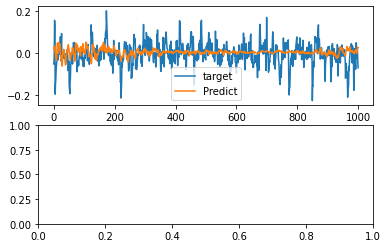

In [13]:
import matplotlib.pyplot as plt

pred = net(test_x.to(device))

fig, axes = plt.subplots(4,1)
fig.set_size_inches(25,5)
axes[0].plot(test_y[-1000:,0],label='target step 1')
axes[1].plot(test_y[-1000:,1],label='target step 2')
axes[2].plot(test_y[-1000:,2],label='target step 3')
axes[3].plot(test_y[-1000:,3],label='target step 4')


#plt.show()

axes[0].plot(pred.detach().cpu().numpy()[-8000:,0],label='Predict step 1')
axes[0].legend()
axes[1].plot(pred.detach().cpu().numpy()[-8000:,1],label='Predict step 2')
axes[1].legend()
axes[2].plot(pred.detach().cpu().numpy()[-8000:,2],label='Predict step 3')
axes[2].legend()
axes[3].plot(pred.detach().cpu().numpy()[-8000:,3],label='Predict step 4')
axes[3].legend()


EPOCH 300, loss at 0.66

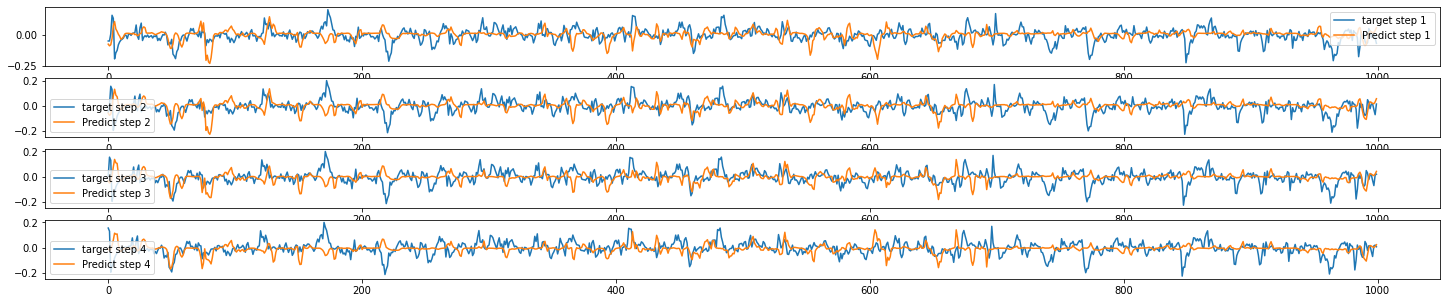

In [16]:
import matplotlib.pyplot as plt

pred = net(test_x.to(device))

fig, axes = plt.subplots(4,1)
fig.set_size_inches(25,5)
axes[0].plot(test_y[-1000:,0],label='target step 1')
axes[1].plot(test_y[-1000:,1],label='target step 2')
axes[2].plot(test_y[-1000:,2],label='target step 3')
axes[3].plot(test_y[-1000:,3],label='target step 4')


#plt.show()

axes[0].plot(pred.detach().cpu().numpy()[-1000:,0],label='Predict step 1')
axes[0].legend()
axes[1].plot(pred.detach().cpu().numpy()[-1000:,1],label='Predict step 2')
axes[1].legend()
axes[2].plot(pred.detach().cpu().numpy()[-1000:,2],label='Predict step 3')
axes[2].legend()
axes[3].plot(pred.detach().cpu().numpy()[-1000:,3],label='Predict step 4')
axes[3].legend()


In [ ]:
print(train_x.shape)

torch.Size([46610, 7, 360])


In [ ]:
from torchinfo import summary
summary(net,input_size=(128,7,3*5*24))

Layer (type:depth-idx)                   Output Shape              Param #
RollingWindowConv                        --                        --
├─Conv1d: 1-1                            [128, 8, 175]             680
├─BatchNorm1d: 1-2                       [128, 8, 175]             16
├─Conv2d: 1-3                            [128, 2, 1, 82]           194
├─BatchNorm2d: 1-4                       [128, 2, 1, 82]           4
├─Sequential: 1-5                        [128, 4]                  --
│    └─Flatten: 2-1                      [128, 164]                --
│    └─Linear: 2-2                       [128, 41]                 6,765
│    └─Sigmoid: 2-3                      [128, 41]                 --
│    └─Linear: 2-4                       [128, 4]                  168
├─Tanh: 1-6                              [128, 4]                  --
Total params: 7,827
Trainable params: 7,827
Non-trainable params: 0
Total mult-adds (M): 18.16
Input size (MB): 1.29
Forward/backward pass size (MB): 

In [1]:
!python newqt.py

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sean'
Index(['Open', 'High', 'Low', 'Close', 'dema9', 'ema100', 'ema200', 'ema300',
       'ema2400', 'ema4800', 'ema6000', 'ema18000', 'ema144000', 'ema288000',
       'D1dema9', 'D1ema100', 'D1ema200', 'D1ema300', 'D1ema2400', 'D1ema4800',
       'D1dema9_std9', 'dema9_std9', 'D1dema9_std100', 'dema9_std100',
       'D1dema9_std300', 'dema9_std300', 'D1dema9_std6000', 'dema9_std6000'],
      dtype='object')
7.298909425735474
/home/sean/miniconda3/envs/qttrade/lib/python3.9/site-packages/pyqtgraph/graphicsItems/PlotCurveItem.py:153: RuntimeWarning: All-NaN slice encountered
  b = (np.nanmin(d), np.nanmax(d))
libGL error: No matching fbConfigs or visuals found
libGL error: failed to load driver: swrast
19
321
710
713
729
853
859
874
898
925
1023
1025
1020
1017
1002
975
962
954
941
933
925
922
917
914
911
919
930
933
927
922
917
914
911
909
911
922
935
938
941
946
951
959
962
964
954
949
943
941
938
943
954
959
962
972